# Around Black-Scholes

We offer you the following practical task on Black-Scholes model. 

Total score is <span style="color:blue">100</span>, which will be converted to $10\%$ of the course grade. You may also get <span style="color:blue">30</span> extra points as bonuses. You have $3$ weeks for this work. **Soft deadline is 31st of March, 16:45 MSK.** Every $24$ hours during the next week **after** the deadline will give a penalty of $15\%$ of the total score. **Hard deadline is 7th of April, 16:45 MSK**.

The file must be sent to **victorantipov99@gmail.com.** Please rename your file as **"SurnameName_HW1.ipynb"** before sending. 

If you have any questions feel free to ask in Telegram https://t.me/igortao or https://t.me/v_antipov.

#### Full name:
#### Faculty:


In [1]:
%%sh
echo "Installing dependencies..."

# ACHTUNG! Be careful here, installing dependencies via pip can break conda environment!
# If you still don't have these libs, uncomment lines below and run cell or install them manually.

#pip install -U pip
#pip install -U pandas numpy matplotlib scipy ipywidgets numba

echo "Done!"

Installing dependencies...
Done!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
from scipy.optimize import root_scalar

from ipywidgets import interact
from ipywidgets import widgets

from dataclasses import dataclass, field
from typing import Union
from copy import deepcopy

from numba import jit

## Episode 1: The Price and It's Derivatives (20 points)

Consider prices of call and put options on stocks in Black-Scholes model:
$$C = S\Phi(d_1) - e^{-rT}K\Phi(d_2), \quad P = e^{-rT}K\Phi(-d_2) - S\Phi(-d_1),$$
where
$$
d_1 = \frac1{\sigma \sqrt{T - t}} \left( \ln \frac{S}{K} + \left( r + \frac{\sigma^2}2 \right) (T - t) \right), \quad 
d_2 = \frac1{\sigma \sqrt{T - t}} \left( \ln \frac{S}{K} + \left( r - \frac{\sigma^2}2 \right) (T - t) \right).
$$
Derive formulas for common greeks <span style="color:blue">(5 points)</span>.:
$$
\begin{aligned}
\Delta_c &= \frac{\partial C}{\partial S} = \Phi(d_1)\\
\Delta_p &= \frac{\partial P}{\partial S} = \Phi(d_1) - 1\\
\gamma_c &= \frac{\partial^2 C}{\partial S^2} = \dfrac{\phi(d_1)}{S\sigma\sqrt{\tau}}\\
\gamma_p &= \frac{\partial^2 P}{\partial S^2} = \dfrac{\phi(d_1)}{S\sigma\sqrt{\tau}}\\
\theta_c &= \frac{\partial C}{\partial t} =-\dfrac{S \phi(d_1) \sigma }{2\sqrt{\tau}} - rKe^{-r\tau}\Phi(d_2)\\
\theta_p &= \frac{\partial P}{\partial t} =-\dfrac{S \phi(d_1) \sigma }{2\sqrt{\tau}} + rKe^{-r\tau}\Phi(-d_2)\\
\nu_c &= \frac{\partial C}{\partial \sigma} = S \phi(d_1) \sqrt{\tau}\\
\nu_p &= \frac{\partial P}{\partial \sigma} =S \phi(d_1) \sqrt{\tau}\\
\rho_c &= \frac{\partial C}{\partial r} = K \tau e^{-r\tau}\Phi(d_2)\\
\rho_p &= \frac{\partial P}{\partial r} = -K \tau e^{-r\tau}\Phi(-d_2)
\end{aligned}
$$

Выведем для $C$, для $P$ получим из call-put parity:
$$
p = c - S + Ke^{-r\tau}
$$

Обозначим $\tau = T - t$, $\phi(x) = \Phi(x)'$,
$$
d_0 = \dfrac{1}{\sigma \sqrt{\tau}} \left( \ln \frac{S}{K} + r \tau \right)
$$Тогда
$$
d_1 = d_0 + \dfrac{\sigma \sqrt{\tau}}{2}, \quad d_2 = d_0 - \dfrac{\sigma \sqrt{\tau}}{2}
$$
Тогда 
$$
d_1^2 = d_0^2 + \dfrac{\sigma^2 {\tau}}{4} + d_0\sigma \sqrt{\tau}, \quad d_2^2 = d_0^2 + \dfrac{\sigma^2 {\tau}}{4} - d_0\sigma \sqrt{\tau}
$$
$$
\phi(d_1) = \frac{1}{\sqrt{2\pi}}\exp\left( -\frac{d_1^2}{2} \right) = 
\frac{1}{\sqrt{2\pi}}\exp\left( -\frac{1}{2} \left( d_0^2 + \dfrac{\sigma^2 {\tau}}{4} \right) \right) \exp 
\left( -\frac{1}{2}d_0 \sigma\sqrt{\tau} \right)
$$
$$
\phi(d_2) =  \frac{1}{\sqrt{2\pi}}\exp\left( -\frac{d_2^2}{2} \right) = \phi(d_1) \exp \left( d_0 \sigma \sqrt{\tau} \right)
$$
$$
d_0 \sigma \sqrt{\tau} = \ln(S/K)+r\tau \to \phi(d_2) = \phi(d_1) \frac{S}{K}e^{r\tau}
$$

### Дельта

$$
\Delta_c = \frac{\partial C}{\partial S} = \Phi(d_1) + S\phi(d_1) \frac{\partial d_1}{\partial S} - e^{-r\tau}K \phi(d_2) \frac{\partial d_2}{\partial S}
$$Видно, что $\dfrac{\partial d_1}{\partial S} = \dfrac{\partial d_2}{\partial S} = \dfrac{1}{S\sigma \sqrt{\tau}}$. Таким образом:
$$
\Delta_c = \Phi(d_1) + \dfrac{1}{S\sigma \sqrt{\tau}} \left( S\phi(d_1) - e^{-r\tau}K \phi(d_2) \right)
=\Phi(d_1) + \dfrac{\phi(d_1)}{S\sigma \sqrt{\tau}} \left( S - e^{-r\tau}K \frac{S}{K}e^{r\tau} \right) = \Phi(d_1)
$$

### Гамма:

$$
\gamma_c = \frac{\partial^2 C}{\partial S^2} = \phi(d_1) \frac{\partial d_1}{S} = \frac{\phi(d_1)}{S\sigma \sqrt{\tau}}
$$

### Тета:

$$
-\theta_c = -\frac{\partial C}{\partial t} = \frac{\partial C}{\partial \tau} = S\phi(d_1) \frac{\partial d_1}{\partial \tau} + re^{-r\tau}K \Phi(d_2) -e^{-r\tau}K \phi(d_2) \frac{\partial d_2}{\partial \tau}
$$
Рассмотрим последнее слагаемое:
$$
e^{-r\tau}K \phi(d_2) = e^{-r\tau} K \frac{S}{K}\phi(d_1) e^{t\tau} = \phi(d_1) S
$$Таким образом:
$$
-\theta_c = re^{-r\tau}K \Phi(d_2) + S\phi(d_1) \left(  \frac{\partial d_1}{\partial \tau} - \frac{\partial d_2}{\partial \tau}  \right)
$$но $d_1 - d_2 = \sigma \sqrt{\tau}$, так что:
$$
-\theta_c = re^{-r\tau}K \Phi(d_2) + \frac{S\phi(d_1) \sigma}{2\sqrt{\tau}}asa
$$

### Вега:


$$
\begin{aligned}
\nu_c &= \frac{\partial C}{\partial \sigma} = S \phi(d_1) \frac{\partial d_1}{\partial \sigma} - e^{-r\tau}K \phi(d_2) \frac{\partial d_2}{\partial \sigma}  
\end{aligned}
$$

Подставляя всё это в формулу получим, что:
$$
\begin{aligned}
\nu_c &= \frac{\partial C}{\partial \sigma} = S \phi(d_1) \frac{\partial d_1}{\partial \sigma} - e^{-r\tau}K \phi(d_2) \frac{\partial d_2}{\partial \sigma}  = 
\phi(d_1)  \left(  S \frac{\partial d_1}{\partial \sigma} - e^{-r\tau}K \frac{S}{K}e^{r\tau}\frac{\partial d_2}{\partial \sigma}  \right) = \\
&=\phi(d_1) S \frac{\partial}{\partial \sigma}  \left(d1-d2\right) = \phi(d_1) S \sqrt{\tau}
\end{aligned}
$$

### Ро

$$
\rho_C = \frac{\partial C}{\partial r} = S \phi(d_1) \frac{\partial d_1}{\partial r} + \tau K e^{-r\tau} \Phi(d_2) - Ke^{-t\tau} \phi(d_2) \frac{\partial d_2}{\partial r}
= \tau K e^{-r\tau} \Phi(d_2) + S \phi(d_1) \frac{\partial}{\partial r} \left( d_2 - d_1 \right) = 
\tau K e^{-r\tau} \Phi(d_2)
$$

Теперь для $P$:
$$
\begin{aligned}
&p = c - S + Ke^{-r\tau}\\
&\Delta_p = \Delta_c - 1 = N(d_1) - 1 \\
&\gamma_p = \gamma_c = \frac{\phi(d_1)}{S\sigma \sqrt{\tau}}\\
&\theta_p = \theta_c + rKe^{-r\tau} = rKe^{-r\tau}\left(1-\Phi(d_2)\right) - \frac{S\phi(d_1) \sigma}{2\sqrt{\tau}}
= rKe^{-r\tau}\Phi(-d_2) - \frac{S\phi(d_1) \sigma}{2\sqrt{\tau}}\\
&\nu_p = \nu_c = \phi(d_1)S\sqrt{\tau}\\
&\rho_p = \rho_c - \tau Ke^{-t\tau} = \tau K e^{-r\tau} \left( \Phi(d_2) - 1 \right) = -\tau K e^{-r\tau}\Phi(-d_2)
\end{aligned}
$$

Write functions for option price and greeks <span style="color:blue">(15 points)</span>.

In [4]:
@dataclass
class StockOption:
    strike_price: Union[float, np.ndarray]
    expiration_time: Union[float, np.ndarray]  # in years
    is_call: bool

@dataclass
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)
        

@dataclass
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)

In [5]:
@dataclass
class MarketState:
    stock_price: Union[float, np.ndarray]
    volatility: Union[float, np.ndarray]  # sigma, annualized
    interest_rate: Union[float, np.ndarray]  # r, assume constant

In [8]:
# Your code
def calc_all(option: StockOption, state: MarketState):
    K = option.strike_price
    tau = option.expiration_time
    S = state.stock_price
    vol = state.volatility
    r = state.interest_rate
    
    sqrttau = np.sqrt(tau) + 1e-15
    D = np.exp(-r * tau)
    
    d1 = ( np.log(S / K) + (r + 0.5 * vol**2) * tau ) / (vol * sqrttau)
    d2 = d1 - vol * sqrttau
    
    Phi = sps.norm.cdf
    phi = sps.norm.pdf
    
    Phi1 = Phi(d1)
    Phi2 = Phi(d2)
    
    phi1 = phi(d1)
    phi2 = phi(d2)
    
    C = S * Phi1 - D * K * Phi2
    P = K * D + C - S
    
    deltaC = Phi1
    deltaP = deltaC - 1
    
    gammaC = phi1 / (S * vol * sqrttau)
    gammaP = gammaC
    
    vegaC = S * phi1 * sqrttau
    vegaP = vegaC
    
    thetaC = -S * phi1 * vol / (2 * sqrttau) - r * K * D * Phi(d2)
    thetaP = thetaC  + r * K * D
    
    rhoC = K * tau * D * Phi2
    rhoP = rhoC - K * tau * D
    return C, P, deltaC, deltaP, gammaC, gammaP, vegaC, vegaP, thetaC, thetaP, rhoC, rhoP
    

def price(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    C, P, deltaC, deltaP, gammaC, gammaP, vegaC, vegaP, thetaC, thetaP, rhoC, rhoP \
                            = calc_all(option, state)
    return C if option.is_call else P

def delta(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    C, P, deltaC, deltaP, gammaC, gammaP, vegaC, vegaP, thetaC, thetaP, rhoC, rhoP \
                            = calc_all(option, state)
    return deltaC if option.is_call else deltaP

def gamma(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    C, P, deltaC, deltaP, gammaC, gammaP, vegaC, vegaP, thetaC, thetaP, rhoC, rhoP \
                            = calc_all(option, state)
    return gammaC if option.is_call else gammaP

def theta(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    C, P, deltaC, deltaP, gammaC, gammaP, vegaC, vegaP, thetaC, thetaP, rhoC, rhoP \
                            = calc_all(option, state)
    return thetaC if option.is_call else thetaP

def vega(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    C, P, deltaC, deltaP, gammaC, gammaP, vegaC, vegaP, thetaC, thetaP, rhoC, rhoP \
                            = calc_all(option, state)
    return vegaC if option.is_call else vegaP

def rho(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    C, P, deltaC, deltaP, gammaC, gammaP, vegaC, vegaP, thetaC, thetaP, rhoC, rhoP \
                            = calc_all(option, state)
    return rhoC if option.is_call else rhoP

In [9]:
strikes = np.linspace(50, 150, 50)
times = np.linspace(0, 2, 50)

calls = CallStockOption(strike_price=strikes.reshape(1, -1),
                        expiration_time=times.reshape(-1, 1))
puts = PutStockOption(strike_price=strikes.reshape(1, -1),
                      expiration_time=times.reshape(-1, 1))

In [10]:
market_state = MarketState(stock_price=100,
                           volatility=0.167,
                           interest_rate=0.1)

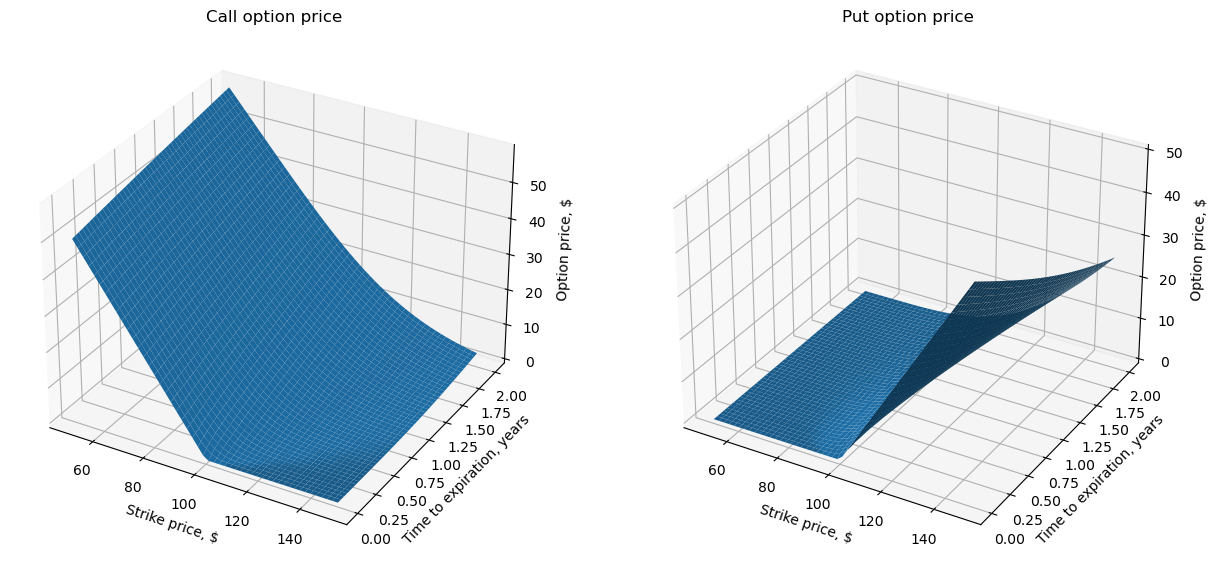

In [11]:
x, y = np.meshgrid(strikes, times)
call_price = price(calls, market_state)
put_price = price(puts, market_state)

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

plt.show()

In [12]:
def plot_all(type_: str = 'Call',
             time_to_expiration: float = 0.25,
             volatility: float = 0.1587,
             stock_price: float = 100.0,
             interest_rate: float = 0.0):
    opt = StockOption(strike_price=np.linspace(20, 200, 100),
                      expiration_time=time_to_expiration,
                      is_call=(type_ == 'Call'))
    
    state = MarketState(stock_price=stock_price,
                        volatility=volatility,
                        interest_rate=interest_rate)
    
    data = {
        'price': price(opt, state),
        'delta': delta(opt, state),
        'gamma': gamma(opt, state),
        'vega': vega(opt, state),
        'theta': theta(opt, state),
        'rho': rho(opt, state)
    }

    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    for name, ax in zip(data, axs.flatten()):
        ax.plot(opt.strike_price, data[name])
        ax.set_title(name)
        ax.set_xlabel('Strike price')
        
    plt.show()

In [13]:
interact(plot_all,
         type_=widgets.Dropdown(options=['Call', 'Put'], value='Call', description='Option type'),
         time_to_expiration=widgets.FloatSlider(min=0.01, max=5.0, step=0.01, value=0.25, description='Time to expiration, years'),
         volatility=widgets.FloatSlider(min=0.1, max=2.0, step=0.01, value=0.1587, description='Volatility, annualized'),
         stock_price=widgets.FloatSlider(min=50.0, max=150.0, value=100.0, description='Stock price'),
         interest_rate=widgets.FloatSlider(min=0, max=0.2, step=0.005, value=0.0, description='Interest rate, annualized'));

interactive(children=(Dropdown(description='Option type', options=('Call', 'Put'), value='Call'), FloatSlider(…

## Тоже самое, но зависимость от stock_price

In [14]:
def plot_all_stock_price(type_: str = 'Call',
             time_to_expiration: float = 0.25,
             volatility: float = 0.1587,
             strike_price: float = 100.0,
             interest_rate: float = 0.0):
    opt = StockOption(strike_price=strike_price,
                      expiration_time=time_to_expiration,
                      is_call=(type_ == 'Call'))
    
    state = MarketState(stock_price=np.linspace(50, 160, 100),
                        volatility=volatility,
                        interest_rate=interest_rate)
    
    data = {
        'price': price(opt, state),
        r'$\Delta$': delta(opt, state),
        r'$\gamma$': gamma(opt, state),
        r'$\nu$': vega(opt, state),
        r'$\theta$': theta(opt, state),
        r'$\rho$': rho(opt, state)
    }

    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    for name, ax in zip(data, axs.flatten()):
        ax.plot(state.stock_price, data[name])
        ax.set_title(name, fontsize=14)
        ax.set_xlabel('Stock price', fontsize=12)
        ax.grid()
    
    plt.show()

interact(plot_all_stock_price,
         type_=widgets.Dropdown(options=['Call', 'Put'], value='Call', description='Option type'),
         time_to_expiration=widgets.FloatSlider(min=0.01, max=5.0, step=0.01, value=0.25, description='Time to expiration, years'),
         volatility=widgets.FloatSlider(min=0.1, max=2.0, step=0.01, value=0.1587, description='Volatility, annualized'),
         strike_price=widgets.FloatSlider(min=50.0, max=150.0, value=100.0, description='Strike price'),
         interest_rate=widgets.FloatSlider(min=0, max=0.2, step=0.005, value=0.0, description='Interest rate, annualized'));

interactive(children=(Dropdown(description='Option type', options=('Call', 'Put'), value='Call'), FloatSlider(…

## Episode 2: Monte-Carlo Strikes Back (50 points)

**1. Write down SDE for risk-neutral price process in Black-Scholes model and its solution <span style="color:blue">(5 points)</span>:**

$$
\begin{cases}
d S_t = r S_t dt + \sigma S_t dW_t\\
S_{t_0} = S_0
\end{cases} \\
S_T = S_0 \exp \left[  (r-0.5\sigma^2)\left(T-t_0\right) + \sigma(W(T)-W(t_0)) \right]
$$

**2. Implement Monte-Carlo option pricing <span style="color:blue">(25 points)</span>**:

In [15]:
# Your code

@jit
def one_simulation(time, S0, r, vol):
    #
    eps = np.random.randn(*time.shape)
    dW = np.sqrt(time[1:]-time[:-1]) * eps[:-1]
    W = np.append( np.zeros((1, )), np.cumsum(dW) ).reshape(*time.shape)
    s = S0 * np.exp( (r - 0.5 * vol ** 2) * time + vol * W )
    return s

def simulate_price(time: Union[float, np.ndarray],
                   n_simulations: int,
                   state: MarketState) -> np.ndarray:
    """Simulates price process evaluating it at given time points
        
    Args:
        time (float or np.darray): time point(s) at which the price shoud be evaluated.
        n_simulations (int): number of simulations.
        state (MarketState): initial market stateto start from.
        
    Returns:
        np.ndarray: numpy array of shape (n_simulations, *np.shape(time)) with price.
    """
    s = [0] * n_simulations
    for i in range(n_simulations):
        s[i] = one_simulation(time, state.stock_price, state.interest_rate, state.volatility)
    s = np.stack(s)
    return s
    
    
def present_value(time: Union[float, np.ndarray],
                  value: Union[float, np.ndarray],
                  interest_rate: float) -> Union[float, np.ndarray]:
    """Calculates present value of payoff(s) occuread at given time(s)
    
    Args:
        time (float or np.ndarray): time(s) in years at which payoff occured
        value (float or np.ndarray): value(s) of the payoff(s)
        interest_rate (float): continuous annualized constant discount rate
    
    Returns:
        float or np.ndarray: continuously discounted value of the payoff
    """
    D = np.exp(-interest_rate * time )
    return D * value

In [16]:
def mc_price(option: StockOption, state: MarketState, n_simulations: int = 10_000) -> Union[float, np.ndarray]:
    price = simulate_price(option.expiration_time, n_simulations, state)
    
    shape = option.strike_price.shape
    if option.is_call:
        payoff = np.maximum(0, price - np.reshape(option.strike_price, (1, *shape)))
    else:
        payoff = np.maximum(0, np.reshape(option.strike_price, (1, *shape)) - price)
        
    return present_value(time=option.expiration_time,
                         value=payoff.mean(0),
                         interest_rate=state.interest_rate)

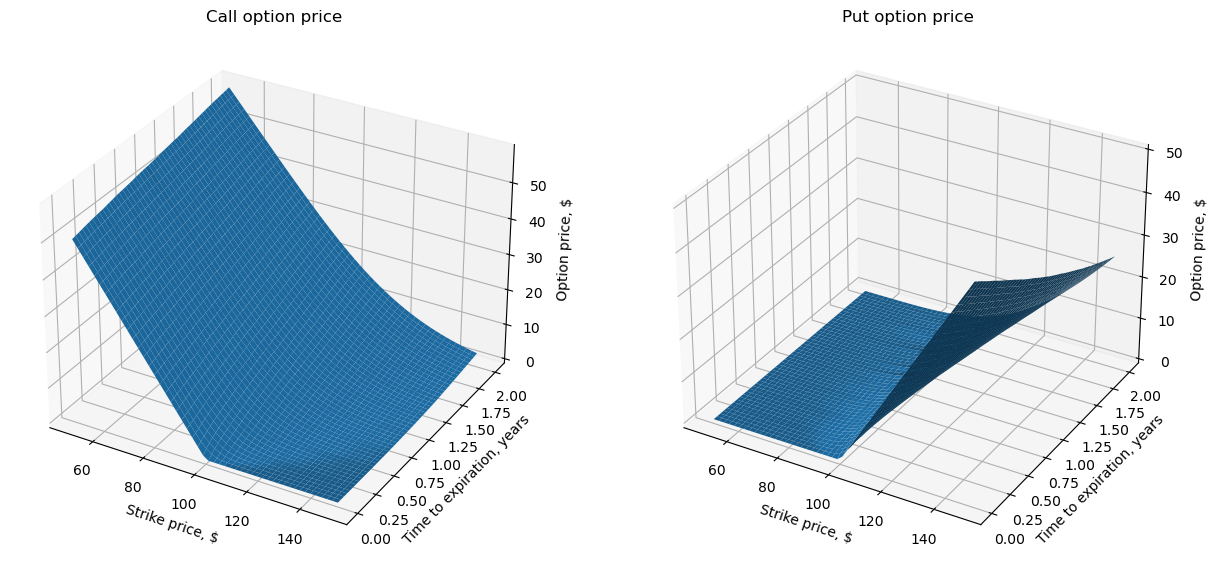

In [17]:
N_SIMULATIONS = 10_000
np.random.seed(42)

x, y = np.meshgrid(strikes, times)
call_price = mc_price(calls, market_state, N_SIMULATIONS)
put_price = mc_price(puts, market_state, N_SIMULATIONS)

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

plt.show()

**3. Error Estimation <span style="color:blue">(20 points)</span>**

It is not sufficient to perform MC simulation, errors should also be estimated.
To obtain price confidence intervals Chebyshev's inequality can be used.
Let $\xi$ be the random variable, and we want to compute it's expectation using MC.
Let $\mu = \mathbb{E} [\xi]$ and $\sigma = \mathrm{var}[\xi]$.
Consider $N$ i.i.d. copies of $\xi$. 
Then:
$$
\mathbb{P} \left( \left\lvert \frac{\xi_1 + \ldots \xi_N}N - \mu \right\rvert \ge \epsilon \right) \le \frac{\sigma^2}{N\epsilon^2}
$$

In practice we usually don't know the variance of $\xi$ and need to estimate it using sample variance.
But in BSM there exists analytical formula for European options payoffs' variances. 
Derive the variances of the call and put opions' final payoff (note the discounting):

$$
\begin{aligned}
    &C_T = \max \left( 0, S_T - K \right)\\
    &C_0 = e^{-rT}\max \left( 0, S_T - K \right) = \max \left(0, e^{-rT}S_T - e^{-rT}K \right) \\
    &S_T = S_0 \exp( (r-0.5\sigma^2) T + \sigma W_T) \\
    &e^{-rT}S_T  = S_0 \exp( -0.5\sigma^2 T + \sigma W_T ) \\
    &C_0 = \max \left(0, S_0 \exp(-0.5\sigma^2 T + \sigma \sqrt{T} Z ) - e^{-rT}K \right)
\end{aligned}
$$где $Z \sim N(0, 1)$. 

$$
    S_0 \exp(-0.5\sigma^2 T + \sigma \sqrt{T} Z ) - e^{-rT}K \geq 0 \Leftrightarrow 
    -0.5\sigma^2 T + \sigma \sqrt{T} Z  \geq \log \frac{e^{-rT}K}{S_0}\Leftrightarrow 
    Z \geq -\frac{\ln \frac{S}{K} + (r-0.5 \sigma^2)T}{\sigma \sqrt{T}} = -d_2
$$

$$
\mathbb{E} C_0 = \frac{1}{\sqrt{2\pi}}\int_{z \geq -d_2} \left(S_0 \exp(-0.5\sigma^2 T + \sigma \sqrt{T} z ) - e^{-rT}K \right) e^{-\frac{z^2}{2}}dz = 
I - e^{-rT}K \Phi(d_2)
$$так как 
$$
\frac{1}{\sqrt{2\pi}} \int_{z\geq -d_2} e^{-z^2/2}dz = 1 - \Phi(-d_2) = \Phi(d_2)
$$

Выделим полный квадрат:

$$
-z^2/2 + \sigma \sqrt{T}z = -\frac{1}{2} \left( z^2 - 2\sigma\sqrt{T}z  \right) = 
-\frac{1}{2} \left( (z-\sigma\sqrt{T}) - \sigma^2T  \right) = -\frac{1}{2} \left( z-\sigma\sqrt{T} \right)^2 + \sigma^2 T
$$

Таким образом:
$$
I = \frac{S_0}{\sqrt{2\pi}}\int_{z \geq -d_2} e^{-\frac{1}{2} \left( z-\sigma\sqrt{T} \right)^2} dz 
= \frac{S_0}{\sqrt{2\pi}}\int\limits_{\tilde{z} \geq -d_2-\sigma\sqrt{T} } e^{-\tilde{z}^2/2} d\tilde{z} 
= S_0 \Phi(d_2 + \sigma\sqrt{T}) = S_0 \Phi(d_1)
$$Итого:
$$
c = \mathbb{E}C_0 = S_0 \Phi(d_1) - e^{-rT}K\Phi(d_2)
$$

\begin{align}
&C_0^2 = \mathbb{I}(Z \geq -d_2)^2 \left(S_0 \exp(-0.5\sigma^2 T + \sigma \sqrt{T} Z ) - e^{-rT}K \right)^2 = \\
&= \mathbb{I}(Z \geq -d_2) \left( S_0^2 \exp(-\sigma^2 T + 2\sigma\sqrt{T}Z) - 2S_0 K \exp( -rT - 0.5\sigma^2T+ \sigma\sqrt{T}Z) + e^{-2rT}K^2\right)\\
&\mathbb{E}C_0^2 = \frac{1}{\sqrt{2\pi}}\int\limits_{z \geq -d_2} \left( S_0^2 \exp(-\sigma^2 T + 2\sigma\sqrt{T}z) - 2S_0 K \exp( -rT - 0.5\sigma^2T+ \sigma\sqrt{T}z) + e^{-2rT}K^2\right) e^{-\frac{z^2}{2}}dz = \\
&= I_1 + I_2 + e^{-2rT}K^2 \Phi(d_2)
\end{align}

$$
-z^2/2 + 2\sigma\sqrt{T}z = -\frac{1}{2} \left( z^2 - 4\sigma \sqrt{T} z\right)
= -\frac{1}{2} \left( (z^2-2\sigma\sqrt{T})^2 - 4\sigma^2T \right) = -\frac{1}{2} \left( z^2-2\sigma\sqrt{T}\right)^2 + 2\sigma^2 T
$$

$$
I_1 = e^{\sigma^2 T}\frac{S_0^2}{\sqrt{2\pi}} \int\limits_{z\geq -d_2} \exp( -\frac{1}{2} \left( z^2-2\sigma\sqrt{T}\right)^2 ) dz = e^{\sigma^2 T}S_0^2 \Phi(d_1 + \sigma \sqrt{T})
$$

$$
I_2 = -2S_0K \exp(-rT) \phi(d_1)
$$

Итого:
$$ 
E C_0^2 = e^{\sigma^2 T} S_0^2 \Phi(d_1 + \sigma \sqrt{T}) - 2S_0K \exp(-rT) \phi(d_1) + e^{-2rT}K^2\Phi(d_2)
$$

Аналогично для $P$:
\begin{align}
&P = \max\left(0, K - S_T \right) \\
&P_0 = \max\left(0, e^{-rT}K - e^{-rT}S_T \right) = \max\left(0, e^{-rT}K - S_0\exp(-0.5\sigma^2T+\sigma\sqrt{T}Z) \right) \\
&\mathbb{E} P_0 = \frac{1}{\sqrt{2\pi}} \int\limits_{z\leq -d_2} \left(e^{-rT}K - S_0\exp(-0.5\sigma^2T+\sigma\sqrt{T}Z) \right)e^{-z^2/2}dz = e^{-rT}K\Phi(-d_2)-S_0\Phi(-d_1) \\
&\mathbb{E} P_0^2 = \frac{1}{\sqrt{2\pi}} \int\limits_{z\leq -d_2} \left(e^{-2rT}K^2 + S_0^2\exp(-\sigma^2T+2\sigma\sqrt{T}Z) - 2S_0Ke^{-rT-0.5\sigma^2T+\sigma{\sqrt{T}}z} \right)e^{-z^2/2}dz = \\
&=e^{-2rT}K^2 \Phi(-d_2) - 2S_0Ke^{-rT} \Phi(-d_1) + S_0^2 \exp(\sigma^2T) \Phi(-d_1-\sigma\sqrt{T})
\end{align}

\begin{align}
&\mathrm{var}[C] = \mathbb{E}C_0^2 - \left(\mathbb{E}C_0\right)^2\\
&\mathrm{var}[P] = \mathbb{E}P_0^2 - \left(\mathbb{E}P_0\right)^2\\
\end{align}

$\varepsilon = \dfrac{\mathrm{var}X}{\sqrt{N\alpha}}$, $\alpha = 0.05$, $X \in \{C, P\}$

Plot error bars for 10000 MC simulations for 11 strikes from 50 to 150 for 0.95 confidence intervals.

In [18]:
# Your code
def calc_var(option: StockOption, state: MarketState):
    K = option.strike_price
    tau = option.expiration_time
    S = state.stock_price
    vol = state.volatility
    r = state.interest_rate
    
    sqrttau = np.sqrt(tau) + 1e-15
    D = np.exp(-r * tau)
    
    d1 = ( np.log(S / K) + (r + 0.5 * vol**2) * tau ) / (vol * sqrttau)
    d2 = d1 - vol * sqrttau
    
    Phi = sps.norm.cdf
    
    Phi1 = Phi(d1)
    Phi2 = Phi(d2)
    
    C = S * Phi1 - D * K * Phi2
    P = K * D + C - S
    
    C2 = np.exp(vol**2 * tau) * S ** 2 * Phi( d1 + vol * np.sqrt(tau)) - 2 * S * K * D * Phi( d1) + D**2*K**2*Phi( d2)
    P2 = np.exp(vol**2 * tau) * S ** 2 * Phi(-d1 - vol * np.sqrt(tau)) - 2 * S * K * D * Phi(-d1) + D**2*K**2*Phi(-d2)
    
    varC = C2 - C**2
    varP = P2 - P**2
    
    return np.sqrt(varC), np.sqrt(varP)

In [19]:
def calc_error(option, state, alpha=0.05, n_simulation=10_000):
    varC, varP = calc_var(option, state)
    var = varC if option.is_call else varP
    error = var / np.sqrt(n_simulation * alpha)
    return error

In [23]:
strikes = np.linspace(50, 150, 11)
times = np.linspace(0.1, 3.1, 5)

calls = CallStockOption(strike_price=strikes.reshape(1, -1),
                        expiration_time=times.reshape(-1, 1))
puts = PutStockOption(strike_price=strikes.reshape(1, -1),
                      expiration_time=times.reshape(-1, 1))

In [24]:
market_state = MarketState(stock_price=100,
                           volatility=0.167,
                           interest_rate=0.05)

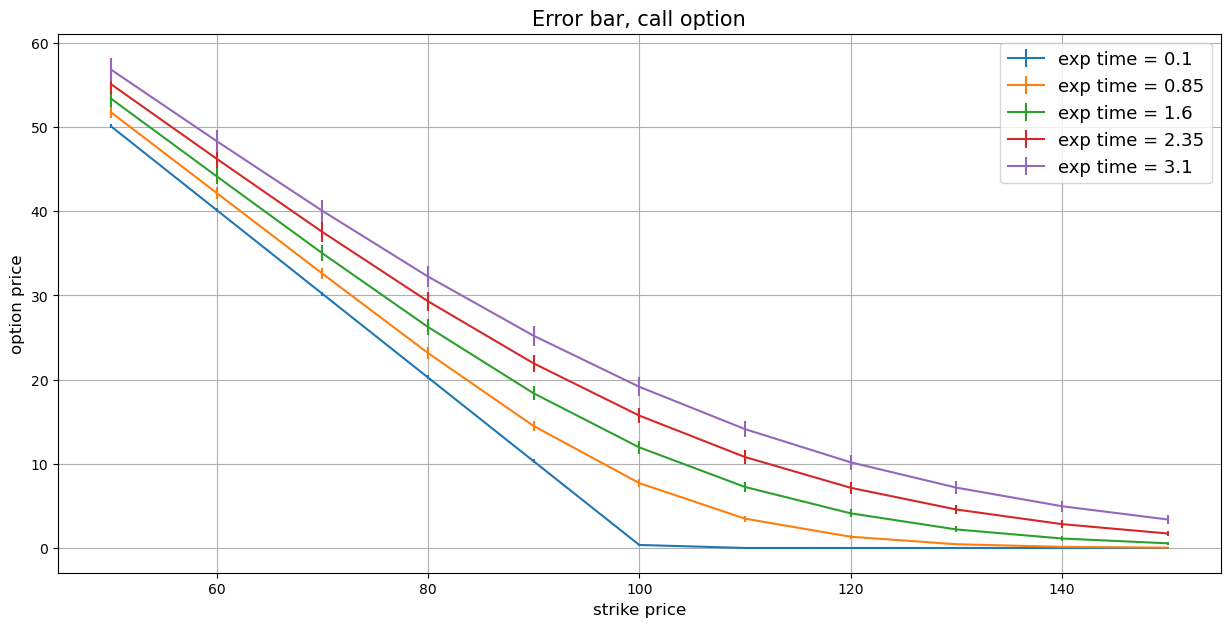

In [25]:
call_price = mc_price(calls, market_state, N_SIMULATIONS)

error = calc_error(calls, market_state, alpha=0.05, n_simulation=10_000 )
plt.figure(figsize=(15, 7))
for i in range(len(times)):
    label = f'exp time = {round(times[i], 2)}'
    plt.errorbar(calls.strike_price.reshape(-1), call_price[i, :], error[i, :], label=label)
plt.grid()
plt.legend(fontsize=13)
plt.title("Error bar, call option", fontsize=15)
plt.xlabel("strike price", fontsize=12)
plt.ylabel("option price", fontsize=12)
plt.show()

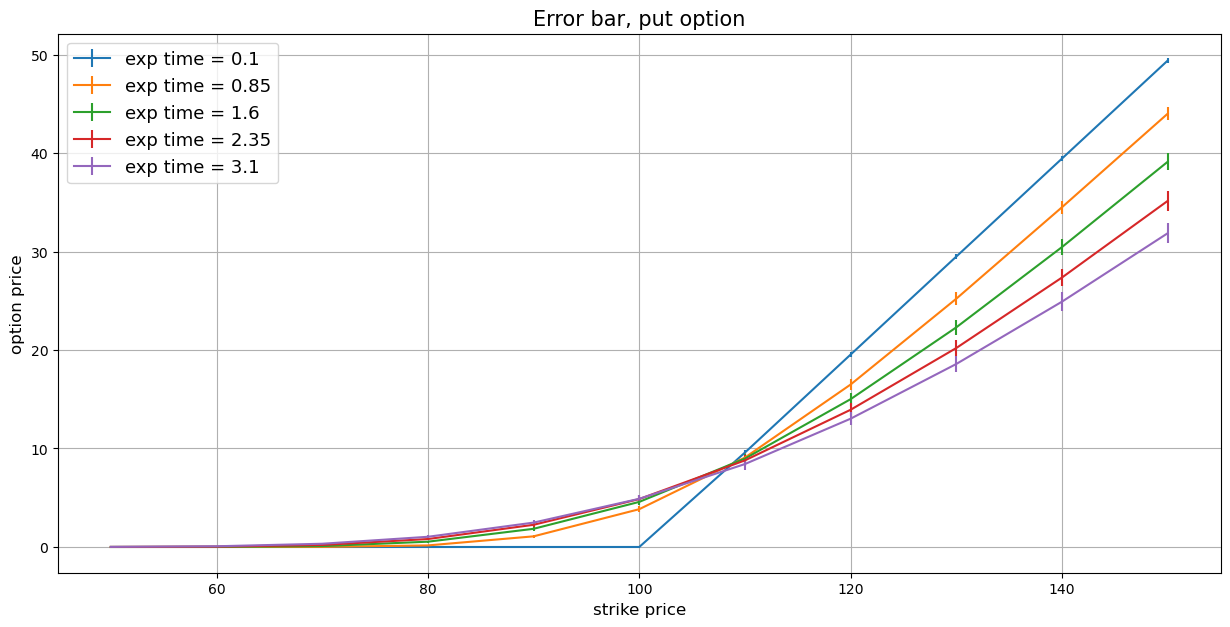

In [26]:
put_price = mc_price(puts, market_state, N_SIMULATIONS)

error = calc_error(puts, market_state, alpha=0.05, n_simulation=10_000 )
plt.figure(figsize=(15, 7))
for i in range(len(times)):
    label = f'exp time = {round(times[i], 2)}'
    plt.errorbar(puts.strike_price.reshape(-1), put_price[i, :], error[i, :], label=label)
plt.grid()
plt.legend(fontsize=13)
plt.title("Error bar, put option", fontsize=15)
plt.xlabel("strike price", fontsize=12)
plt.ylabel("option price", fontsize=12)
plt.show()

## Episode 3: The Phantom Implied Volatility (30 points + 30 extra points)

**1. Vanilla Root Finding (30 points)**

Here you are to implement algorithm for computing implied volatility of option.
Volatility in MarketState that is passed to the IV function must be ignored.
Your algorithm should be stable! Comment on the results please.

Hint: use scipy library (https://docs.scipy.org/doc/scipy/reference/optimize.html).

In [27]:
from scipy.optimize import root_scalar
def calc_iv(option: CallStockOption, state: MarketState, option_price: float):
    """Calculates implied volatility
    
    Args:
        option (CallStockOption): call option parameters, 
            call is used due to the uniqueness of the solution
        state (MarketState): market state, volatility parameter is ignored
        option_price (float): actual option price
    
    Returns:
        float: volatility that produced passed option price
    """
    K = option.strike_price
    tau = option.expiration_time
    S = state.stock_price
    r = state.interest_rate
    sqrttau = np.sqrt(tau) + 1e-13
    D = np.exp(-r * tau)
    Phi = sps.norm.cdf
    phi = sps.norm.pdf
    def foo(vol):
        d1 = ( np.log(S / K) + (r + 0.5 * vol**2) * tau ) / (vol * sqrttau)
        d2 = d1 - vol * sqrttau
        Phi1 = Phi(d1)
        Phi2 = Phi(d2)
        C = S * Phi1 - D * K * Phi2
        return C - option_price
    def prime(vol):
        d1 = ( np.log(S / K) + (r + 0.5 * vol**2) * tau ) / (vol * sqrttau)
        return S * phi(d1) * sqrttau
    #ans=root_scalar(f=foo, xb, fprime=prime, method='newton')
    ans = root_scalar(foo, bracket=[0.01, 100], method='brentq')
    return ans.root
    
    

In [28]:
df = pd.read_csv("calls.csv")
df

,strike,price,yahoo_iv,stock_price,time_to_expiration
0,150.0,288.73,0.8307,430.78,0.83
1,160.0,278.77,0.7858,430.78,0.83
2,190.0,242.60,0.5232,430.78,0.83
3,200.0,232.63,0.4950,430.78,0.83
4,250.0,183.87,0.4016,430.78,0.83
...,...,...,...,...,...
86,550.0,1.34,0.1594,430.78,0.83
87,560.0,1.02,0.1601,430.78,0.83
88,565.0,0.89,0.1605,430.78,0.83
89,600.0,0.42,0.1681,430.78,0.83


In [29]:
PLACEHOLDER_VOL = 0.2

In [30]:
market_state = MarketState(stock_price=df.at[0, "stock_price"],
                           volatility=PLACEHOLDER_VOL,
                           interest_rate=0.0)

In [31]:
for idx, row in df.iterrows():
    option = CallStockOption(strike_price=row["strike"],
                             expiration_time=row["time_to_expiration"])
    df.at[idx, "iv"] = calc_iv(option, market_state, row["price"])

Mean squared error: 0.00004


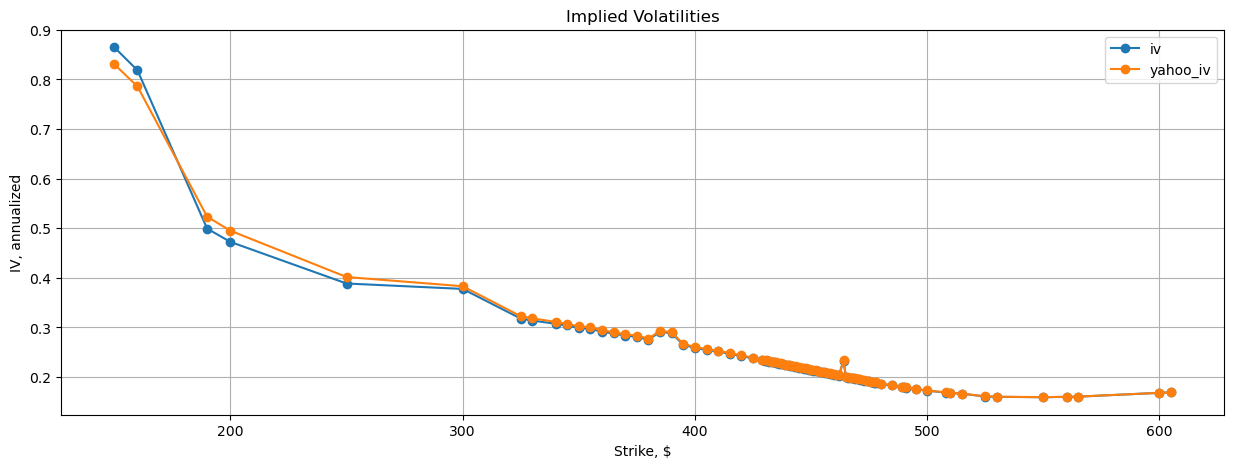

In [32]:
_, ax = plt.subplots(figsize=(15, 5))

print("Mean squared error: {:.5f}".format(np.mean((df["iv"] - df["yahoo_iv"])**2)))

for col in ("iv", "yahoo_iv"):
    ax.plot(df["strike"], df[col], "o-", label=col)
ax.legend()
ax.set_xlabel("Strike, $")
ax.set_ylabel("IV, annualized")
ax.set_title("Implied Volatilities")
plt.grid()
plt.show()

**2. Newton Bisection Hybrid (Newt-Safe) (30 extra points)**

Implement the root finding algorithm as in https://www.youtube.com/watch?v=FD3BPTMGJds. Comment on the results and compare them with previous. 

In [48]:
#YOUR CODE HERE